## Import the dataset
[coursework doc](https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs342/coursework_cs342_2020-2021.pdf)
[iterative process](https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs342/iterativeprocess.pdf)

Dataset information:
1) sepal length in cm 
2) sepal width in cm
3) petal length in cm
4) petal width in cm

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import math

#import the flower data
df = pd.read_csv("./iris.data", header=None)
df[4].replace('Iris-setosa',0,inplace=True)
df[4].replace('Iris-versicolor',1,inplace=True)
df[4].replace('Iris-virginica',2,inplace=True)
print(df)

       0    1    2    3  4
0    5.1  3.5  1.4  0.2  0
1    4.9  3.0  1.4  0.2  0
2    4.7  3.2  1.3  0.2  0
3    4.6  3.1  1.5  0.2  0
4    5.0  3.6  1.4  0.2  0
..   ...  ...  ...  ... ..
145  6.7  3.0  5.2  2.3  2
146  6.3  2.5  5.0  1.9  2
147  6.5  3.0  5.2  2.0  2
148  6.2  3.4  5.4  2.3  2
149  5.9  3.0  5.1  1.8  2

[150 rows x 5 columns]


## Method A
Convert the 4D data into 2D using PCA and visualise, based on SVD from lab 5

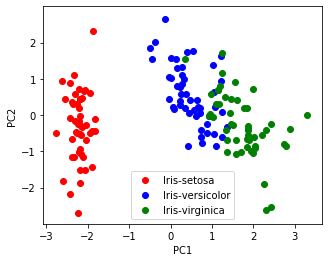

In [2]:
from sklearn import preprocessing

# Code from lab 5 for PCA using SVD, uses preprocessing from sklearn to centre the data
def pca_decomposition(dataset):
    data_centred = (dataset - dataset.mean()) / dataset.std()
#     data_scaled = preprocessing.scale(dataset)
    U, s, V = np.linalg.svd(data_centred, full_matrices=True)
    return U, s, V

x_features = df[df.columns[:-1]]
x_label = df[df.columns[-1]]
U, s, V = pca_decomposition(x_features)



projected_U = U[:, :2] #only take the first 2 components because we want 2D reduction
projected_U *= s[:2] #you do X * V to project data which is equivalent to U * S so we can just do that (apparently it's quicker)

dimension_reduced_iris = pd.DataFrame(data = projected_U, columns = ['PC1', 'PC2'])
#add the labels back to the data so it can be used in the graph..
dimension_reduced_iris["label"] = x_label


plt.figure(figsize=(5, 4))
#setosa
setosa = dimension_reduced_iris.loc[dimension_reduced_iris['label'] == 0]
plt.scatter(setosa["PC1"], setosa["PC2"], c="r", marker="o")

#versicolor
versicolor = dimension_reduced_iris.loc[dimension_reduced_iris['label'] == 1]
plt.scatter(versicolor["PC1"], versicolor["PC2"], c="b", marker="o")

#virginica
virginica = dimension_reduced_iris.loc[dimension_reduced_iris['label'] == 2]
plt.scatter(virginica["PC1"], virginica["PC2"], c="g", marker="o")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(["Iris-setosa", "Iris-versicolor", "Iris-virginica"])

plt.show()


## Method B
Multi class perceptron on the 2d subspace. Make sure to encourage the largest predicted value to be the correct classification. Use the lab as a starting point.


### Hints
1) Define the class labels as numerical values, e.g., use 0, 1 and 2, for the three labels.
2) Determine how to update the weights of the linear classifier that provides the maximum predicted value and those of the
linear classifier associated with the correct class when the prediction is incorrect.
3) Recall adding a bias to the linear classifiers.
4) The algorithm may need to run for several iterations, as the data is not linearly separable. In each iteration, all training
samples should be used in random order. Train your

### Convert the dataset labels into numbers rather than text
0 = Iris-setosa
1 = Iris-versicolor
2 = Iris-virginica

In [3]:
class MultiClassPerceptron():
    def __init__(self, data, classes, iterations):
        self.data = data
        self.classes = classes
        self.iterations = iterations
        
         
        #Create the weights for each classes with a bias term of 1 at the 0 index for each weight vector
        #Has the label included at this point and not the bias so it balanced out in size
        feature_count = len(self.data[0])
        self.weights = {}
        for i in self.classes:
            self.weights[i] = np.array([0.0 for i in range(feature_count)])
            
        #Add the bias (1) to each of the feature vectors for all training examples
        for idx, feature_vector in enumerate(self.data):
            self.data[idx] = [1.0] + self.data[idx]
        
    def train(self):
        #Run the training for the specified number of iterations
        for iteration in range(self.iterations):
            random.shuffle(self.data)
            
            for n in self.data:
                features = n[:-1]
                label = int(n[-1:][0])
                
                #current largest predicted value
                argmax = 0
                #current predicted class
                predicted_class = random.choice(self.classes)
                
                #classify the training examples for all classifiers (each class)
                for idx, c in enumerate(self.classes):
                    classification = np.dot(self.weights[c], features)
                    
                    if classification >= argmax:
                        argmax = classification
                        predicted_class = c
                        #print("Classification for classifier " + str(c) + " = " + str(classification) + " actual (" + str(label) + ")")
                
                #Refine the solution if the prediction is wrong
                if not (str(predicted_class) == str(label)):
                    #Add weight to the right class based on the features of current testing example
                    self.weights[str(label)] += np.array(features)
                    #Subtract weight to the one we predicted incorrectly
                    self.weights[str(predicted_class)] -= np.array(features)
                    #Restart on all the examples again (without shuffling again)
                    continue
    
    def predict(self, features):
        #add the bias
        features = [1] + features
        
        argmax = 0
        predicted_class = self.classes[0]
        
        #for each classifier run it on the example only returning the largest predicted value
        for c in self.classes:
            classification = np.dot(self.weights[c], features)
            if classification >= argmax:
                argmax = classification
                predicted_class = c
            
        return predicted_class
    
    def get_weights(self):
        return self.weights
    
    def get_accuracy(self):
        inaccurate_predictions = 0
        for example in self.data:
            #remove the bias and the label, store the label to compare against after prediction
            label = int(example[-1])
            features = example[1:-1]
            predicted_class = self.predict(features)
            if str(predicted_class) != str(label):
                inaccurate_predictions += 1
        return (len(self.data)-inaccurate_predictions)/len(self.data)
    
        
features = df.iloc[:,:-1].values.tolist()
labels = df.iloc[:,-1:].values.tolist()

accuracy_results = []
mcp = MultiClassPerceptron(df.values.tolist(), ["0", "1", "2"], 50)
mcp.train()

print(mcp.get_accuracy())

0.9466666666666667



### 2D Multiclass perceptron

{'0': array([ -1.        , -10.65856498,  -1.63618168]), '1': array([ 6.        , -1.24617832, -0.58609613]), '2': array([-5.        , 11.9047433 ,  2.22227781])}
-1.6361816823515238
-0.5860961300283662
2.222277812379887


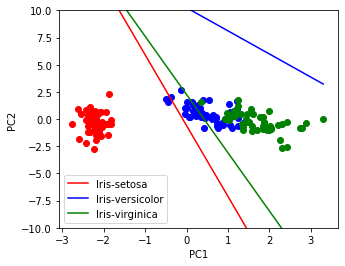

0.9133333333333333


In [4]:
projected_list = projected_U.tolist()
for idx, label in enumerate(labels):
    projected_list[idx].append(label[0])

accuracy_results = []

twod_mcp = MultiClassPerceptron(projected_list, ["0", "1", "2"], 50)
twod_mcp.train()

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)

#setosa
setosa = dimension_reduced_iris.loc[dimension_reduced_iris['label'] == 0]
plt.scatter(setosa["PC1"], setosa["PC2"], c="r", marker="o")

#versicolor
versicolor = dimension_reduced_iris.loc[dimension_reduced_iris['label'] == 1]
plt.scatter(versicolor["PC1"], versicolor["PC2"], c="b", marker="o")

#virginica
virginica = dimension_reduced_iris.loc[dimension_reduced_iris['label'] == 2]
plt.scatter(virginica["PC1"], virginica["PC2"], c="g", marker="o")

new_x_data = []
new_y_data = []

for i in projected_list:
    new_x_data.append(i[1])
    new_y_data.append(i[2])

print(twod_mcp.get_weights())
for i in range(3):
    #calculate the decision boundaries
    
    markers = ["r", "b", "g"]
    

    x0_1 = np.amin(new_x_data)
    x0_2 = np.amax(new_x_data)
    print(twod_mcp.get_weights()[str(i)][2])
    x1_1 = (-twod_mcp.get_weights()[str(i)][1] * x0_1 - twod_mcp.get_weights()[str(i)][0]) / twod_mcp.get_weights()[str(i)][2]
    x1_2 = (-twod_mcp.get_weights()[str(i)][1] * x0_2 - twod_mcp.get_weights()[str(i)][0]) / twod_mcp.get_weights()[str(i)][2]

    ax.plot([x0_1, x0_2],[x1_1, x1_2], color=markers[i])


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
plt.ylim([-10,10])
plt.show()

print(twod_mcp.get_accuracy())


{'0': array([ 6. , -4.8,  0.8]), '1': array([-6. ,  4.8, -0.8])}


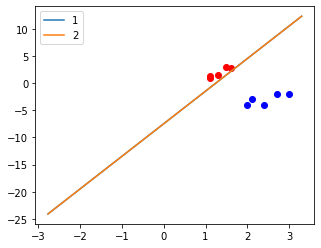

0
Accuracy: 1.0


In [5]:
random_list=[
             [1, 1, 0], [1.6, 2.8, 0], [1.5, 3, 0], [1.3, 1.4, 0], [1.1, 1.2, 0],
             [2, 4, 1], [3, 2, 1], [2.1, 3, 1], [2.4, 4, 1], [2.7, 2, 1]
            ]
othermcp = MultiClassPerceptron(random_list, ["0", "1"], 50)
othermcp.train()

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)

plt.scatter([1.1, 1.6, 1.5, 1.3, 1.1], [1.0, 2.8, 3.0, 1.4, 1.2], c="r", marker="o")

plt.scatter([2.0, 3.0, 2.1, 2.4, 2.7], [-4.0, -2.0, -3.0, -4.0, -2.0], c="b", marker="o")

print(othermcp.get_weights())
for i in range(2):
    #calculate the decision boundaries
    
    x0_1 = np.amin(new_x_data)
    x0_2 = np.amax(new_x_data)
    x1_1 = (-othermcp.get_weights()[str(i)][1] * x0_1 - othermcp.get_weights()[str(i)][0]) / othermcp.get_weights()[str(i)][2]
    x1_2 = (-othermcp.get_weights()[str(i)][1] * x0_2 - othermcp.get_weights()[str(i)][0]) / othermcp.get_weights()[str(i)][2]

    ax.plot([x0_1, x0_2],[x1_1, x1_2])


plt.legend(["1", "2"])
plt.show()

inaccurate_predictions = 0
for i in random_list:
    prediction = int(othermcp.predict(i[1:-1]))
    actual = i[3]
    if actual != prediction:
        inaccurate_predictions += 1

print(inaccurate_predictions)
accuracy = (15-inaccurate_predictions)/15
print("Accuracy: " + str(accuracy))

# Kernel Method
Projecting the data onto a higher dimensional subspace so that, hopefully, the data becomes seperable

In [65]:
def l2Squared(xi, xj):
    return np.linalg.norm(np.array(xi) - np.array(xj), 2) ** 2

#Creating the kernel matrix, it is the dot product between all examples in the data set
    
#Computes the kernel matrix K (nxn)
def computeKernelMatrix(data, sigma):
    K = []
    for idx, i in enumerate(data):
        K.append([])
        for idxTwo, j in enumerate(data):
             #K[idx].append(np.dot(i, j))
                rbfKernel = np.exp(-(1/(2*(sigma**2))) * l2Squared(i, j)) 
                K[idx].append(rbfKernel)
            
    return K
            
def computeNormalisedKernelMatrix(K):
    #Need to generate the A matrix which is an nxn matrix with all values set to 1/n (n being training sample size)
    A = []
    n = len(np.array(K).flatten())
    for i in range(int(math.sqrt(n))):
        A.append([])
        for j in range(int(math.sqrt(n))):
            A[i].append(1/n)
            
    #Now use the formula ~K = K-AK-KA+(AK)A
    normalisedK = K-np.dot(A, K) - np.dot(K, A) + np.dot((np.dot(A, K)), A)
    return normalisedK

def kpca(normalisedK, components):
    #dont need to center the data here, it is already done by figuring out the normalised K
    U, s, V = np.linalg.svd(normalisedK, full_matrices=True)
    eigenvectors = V.T
    eigenvalues = s**2/(normalisedK.shape[0])
    return np.column_stack([eigenvectors[:, components] for i in range(components)]) 

class GridSearch():
    def __init__(self, data, pc_min, pc_max, gammaMin, gammaMax):
        self.data = data
        self.pc_min = pc_min
        self.pc_max = pc_max
        self.gammaMin = gammaMin
        self.gammaMax = gammaMax
        
    def calculateBestParameters(self):
        #for all the principal components
        for pc_components in range(self.pc_min, self.pc_max+1):
            #for all the possible gamma values
            pass
        for gamma in np.arange(self.gammaMin, self.gammaMax, 0.1):
            gamma = round(gamma, 2)
            print(gamma)
            
    def getAccuracyForParameters(self, pcs, gamma):
        K = computeKernelMatrix(self.data, gamma)
        NormalisedK = computeNormalisedKernelMatrix(K)
        
        #Apply kernel decompositon
        projected_kpca = kpca(NormalisedK, pcs)
        
        #Dynamic column count so create the titles
        columns = []
        for i in range(pcs):
            columns.append("PC" + str(i+1))
        
        #Convert to dataframe and add back the labels
        kpca = pd.DataFrame(data = projected_kpca, columns = columns)
        kpca["label"] = x_label
        
        #Train the MCP
        mcp = MultiClassPerceptron(kpca.values.tolist(), ["0", "1", "2"], 50)
        return mcp.get_accuracy()
        


#Calculate the variance of the features so we can use this to determine the gamma of the rbf kernel


gs = GridSearch(features, 1, 150, 0.35, 1.11)
gs.calculateBestParameters()


0.35
0.45
0.55
0.65
0.75
0.85
0.95
1.05
